# Category Prediction on BBC-news data

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

import json, re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from scipy import sparse as sp_sparse

from sklearn.model_selection import train_test_split

data_dir = '../nlp_datasets/13_twitter_sentiment/'

In [2]:
def load_data():
    with open(data_dir+'train_twits.json', 'r') as f:
        twits = json.load(f)
    df = pd.DataFrame(twits['data'])
    return df
    
data = load_data()

In [3]:
print (f"data shape:{data.shape}")
data.head(2)

data shape:(1548010, 3)


,message_body,sentiment,timestamp
0,$FITB great buy at 26.00...ill wait,2,2018-07-01T00:00:09Z
1,@StockTwits $MSFT,1,2018-07-01T00:00:42Z


In [4]:
# cut the data short to make learning faster
df_top = data#.loc[:500000]

In [5]:
df= df_top.copy()

print ('unique sentiments:', df.sentiment.unique() )
# convert the labels to [0-4] instead of [-2, 2]
df['sentiment'] = df['sentiment'].apply(lambda x:x+2)
print ('unique sentiments:', df.sentiment.unique() )
df.head(4)

unique sentiments: [ 2  1  0 -2 -1]
unique sentiments: [4 3 2 0 1]


,message_body,sentiment,timestamp
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z
1,@StockTwits $MSFT,3,2018-07-01T00:00:42Z
2,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z
3,$AMD I heard there’s a guy who knows someone w...,3,2018-07-01T00:01:47Z


## Class (Im)balance

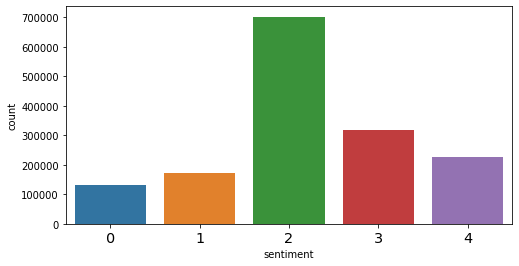

In [6]:
fig, ax = plt.subplots(1,1,figsize=(8,4));
sns.countplot(df['sentiment'], ax=ax);
plt.xticks(fontsize='x-large');

In [7]:
def find_counts(df):
    df_counts =df.groupby("sentiment", axis=0).count()
    df_counts["ratio (pct)"] = 100*df_counts["message_body"]/sum(df_counts["message_body"])
    return df_counts

In [8]:
find_counts(df)

,message_body,timestamp,ratio (pct)
sentiment,,,
0,131968,131968,8.525010
1,173130,173130,11.184036
2,701597,701597,45.322511
3,316447,316447,20.442181
4,224868,224868,14.526263


In [9]:
def balance_class(df, col='sentiment'):
    dfb=df.copy()
    counts = dict(dfb[col].value_counts())
    print ("initial counts for each classes:", counts)
    min_count = min(counts.values())
    min_indx  = [k for k in counts.keys() if counts[k]==min_count][0]
    print ("min_index:", min_indx, "min count:", min_count)
    
    for s in dfb[col].unique():
        delete_after = dfb[dfb[col]==min_indx].shape[0] 
        indices_to_delete = dfb[dfb[col]==s].index.values[delete_after:]
        dfb = dfb.drop(index=indices_to_delete, axis=0)
    return dfb

df=balance_class(df, col='sentiment')
find_counts(df)

initial counts for each classes: {2: 701597, 3: 316447, 4: 224868, 1: 173130, 0: 131968}
min_index: 0 min count: 131968


,message_body,timestamp,ratio (pct)
sentiment,,,
0,131968,131968,20.0
1,131968,131968,20.0
2,131968,131968,20.0
3,131968,131968,20.0
4,131968,131968,20.0


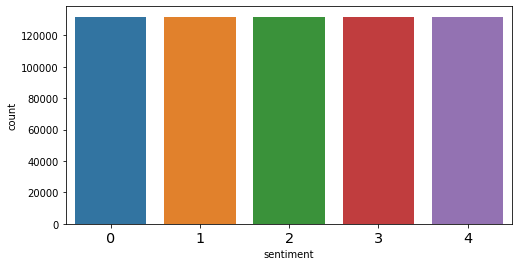

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8,4));
sns.countplot(df['sentiment'], ax=ax);
plt.xticks(fontsize='x-large');

In [11]:

import re

STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    text = text.lower() # lowercase text
    text = re.sub(r'https?://\S+', ' ', text)# Replace URLs with a space
    text = re.sub(r'\$\S+', ' ', text)       # Replace ticker symbols with a space
    text = re.sub(r'\@\S+', ' ', text)       # Replace StockTwits usernames with a space.
    text = re.sub(r'[^a-zA-Z]', ' ', text)   # Replace everything not a letter with a space        
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwors from text
    return text

In [12]:
df['message_processed'] = df['message_body'].apply(text_prepare)
df.head(5)

,message_body,sentiment,timestamp,message_processed
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,great buy ill wait
1,@StockTwits $MSFT,3,2018-07-01T00:00:42Z,
2,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z,staanalystalert jefferies maintains rating hol...
3,$AMD I heard there’s a guy who knows someone w...,3,2018-07-01T00:01:47Z,heard guy knows someone thinks somebody knows ...
4,$AMD reveal yourself!,2,2018-07-01T00:02:13Z,reveal


In [13]:
df  = df[df['message_processed']!='']
df.head(5)

,message_body,sentiment,timestamp,message_processed
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,great buy ill wait
2,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z,staanalystalert jefferies maintains rating hol...
3,$AMD I heard there’s a guy who knows someone w...,3,2018-07-01T00:01:47Z,heard guy knows someone thinks somebody knows ...
4,$AMD reveal yourself!,2,2018-07-01T00:02:13Z,reveal
5,$AAPL Why the drop? I warren Buffet taking out...,3,2018-07-01T00:03:10Z,drop warren buffet taking position


In [15]:
df.shape

(643496, 4)

In [16]:
df.to_csv("stock_twits_processed.csv", index=False)